In [1]:
import numpy as np, pandas as pd, geopandas as gpd, fiona
from shapely.geometry import box

# Optional (faster multiply & small Gaussian smoothing):
try:
    from scipy.sparse import coo_matrix, csr_matrix
    from scipy.ndimage import gaussian_filter
    SCIPY = True
except Exception:
    SCIPY = False

EXCEL = "data/input/base-pop-historiques-1876-2020.xlsx"
GPKG  = "data/input/ADE_4-0_GPKG_WGS84G_FRA-ED2025-08-15.gpkg"
DEP_CODE = "01"
YEARS = sorted(list(range(1876, 1912, 5)) + [1936, 1931, 1926, 1921])
TARGET_CRS = "EPSG:2154"
N = 64   # fits your compute budget

def find_commune_layer(gpkg):
    L = [L for L in fiona.listlayers(gpkg) if L.lower() in {"commune","communes"}]
    if not L: raise RuntimeError("COMMUNE layer not found.")
    return L[0]

def load_communes_ain(gpkg, dep="01"):
    L = find_commune_layer(gpkg)
    com = gpd.read_file(gpkg, layer=L).to_crs(TARGET_CRS)
    code_cols = ["INSEE_COM","insee_com","code_insee","CODE_INSEE","CODGEO","codgeo","insee"]
    cc = next((c for c in code_cols if c in com.columns), None)
    if cc is None: raise RuntimeError("No commune INSEE code column in GPKG.")
    com["CODGEO"] = com[cc].astype(str).str.zfill(5)
    ain = com[com["CODGEO"].str[:2]==dep].copy()
    if ain.empty: raise RuntimeError("Ain subset is empty; check GPKG.")
    return ain

def build_grid_and_barrier_polygons(ain_gdf, N):
    """Return (minx, miny, dx, dy, barrier[N,N], grid_gdf with cell polygons & indices)."""
    ain_gdf = ain_gdf.to_crs(TARGET_CRS)
    minx, miny, maxx, maxy = ain_gdf.total_bounds
    dx = (maxx - minx)/N; dy = (maxy - miny)/N

    dept_poly = ain_gdf.unary_union

    cells = []
    for iy in range(N):
        y0 = miny + iy*dy; y1 = y0 + dy
        for ix in range(N):
            x0 = minx + ix*dx; x1 = x0 + dx
            geom = box(x0, y0, x1, y1)
            allowed = geom.intersects(dept_poly)  # allow partial-overlap boundary cells
            cells.append({"iy": iy, "ix": ix, "cell_id": iy*N + ix, "allowed": allowed, "geometry": geom})

    grid = gpd.GeoDataFrame(cells, crs=TARGET_CRS)
    barrier = ~grid["allowed"].to_numpy().reshape(N, N)  # True = forbidden
    return (minx, miny, dx, dy, barrier, grid)

def build_area_fraction_matrix(ain_communes, grid):
    """
    Build sparse A (num_cells × num_communes) where A[i,j] = area(cell_i ∩ commune_j) / area(commune_j).
    Also returns the communes in a fixed order & their CODGEO list.
    """
    com = ain_communes[["CODGEO", "geometry"]].copy()
    com["area"] = com.geometry.area.values
    # spatial index over grid cells to avoid all-pairs
    sidx = grid.sindex

    rows, cols, vals = [], [], []
    for j, (geom_j, area_j) in enumerate(zip(com.geometry, com["area"])):
        if area_j <= 0:
            continue
        cand = list(sidx.query(geom_j, predicate="intersects"))
        if not cand:
            continue
        inter = grid.geometry.iloc[cand].intersection(geom_j).area.values
        mask = inter > 0
        if mask.any():
            rows.extend([grid["cell_id"].iloc[c] for c, m in zip(cand, mask) if m])
            cols.extend([j] * int(mask.sum()))
            vals.extend((inter[mask] / area_j).tolist())

    if SCIPY:
        A = csr_matrix((vals, (rows, cols)), shape=(len(grid), len(com)))
    else:
        # Fallback dense (OK at N<=96 and ~400 communes, but uses more RAM)
        A = np.zeros((len(grid), len(com)), dtype=float)
        A[np.array(rows), np.array(cols)] = np.array(vals)

    # Sanity: area fractions per commune should sum to ~1
    if SCIPY:
        col_sums = np.array(A.sum(axis=0)).ravel()
    else:
        col_sums = A.sum(axis=0)
    max_dev = float(np.max(np.abs(col_sums - 1)))
    if max_dev > 1e-6:
        print(f"[warn] max |sum(frac)-1| across communes = {max_dev:.2e}")

    return A, com

def rasterize_year_area(A, com, long_df, year, N, barrier):
    pop = (long_df[long_df["year"]==year]
           .set_index("CODGEO")["pop"]).reindex(com["CODGEO"]).fillna(0.0).to_numpy()
    if SCIPY:
        vec = A @ pop  # shape: (#cells,)
    else:
        vec = A.dot(pop)  # dense fallback
    Z = vec.reshape(N, N)
    Z[barrier] = 0.0
    return Z

# -------------------- PIPELINE --------------------

# 1) Load population table (Ain only)
df = pd.read_excel(EXCEL)
df = df[df["DEP"].astype(str).str.zfill(2)==DEP_CODE].copy()
pop_cols = [f"pop{y}" for y in YEARS]
long = df[["CODGEO","LIBGEO","DEP"] + pop_cols].melt(
    id_vars=["CODGEO","LIBGEO","DEP"], value_vars=pop_cols,
    var_name="year", value_name="pop"
)
long["year"] = long["year"].str.replace("pop","",regex=False).astype(int)
long["pop"] = long["pop"].fillna(0).astype(float)

# 2) Load Ain commune polygons
ain = load_communes_ain(GPKG, DEP_CODE).to_crs(TARGET_CRS)

# 3) Grid + barrier (polygon-aware)
minx, miny, dx, dy, barrier, grid = build_grid_and_barrier_polygons(ain, N)
x_edges = minx + np.arange(N+1)*dx
y_edges = miny + np.arange(N+1)*dy

# 4) Precompute area-fraction matrix (cells × communes)
print("Computing commune↔grid overlaps… (one-time)")
A, com = build_area_fraction_matrix(ain, grid)
print("Done. Nonzeros:", (A.nnz if SCIPY else np.count_nonzero(A)))

# 5) Rasterize all years via matrix multiply
X_true = np.stack([rasterize_year_area(A, com, long, y, N, barrier) for y in YEARS], axis=0)
M = X_true.reshape(len(YEARS), -1).sum(1)

# (Optional) VERY LIGHT smoothing to de-spike tiny communes further.
# Keep sigma small (e.g., 0.6–1.0 grid cells) and re-normalize mass each year.
APPLY_SMOOTH = False
SMOOTH_SIGMA = 0.8   # in grid cells
if APPLY_SMOOTH and SCIPY:
    X_smooth = np.empty_like(X_true)
    for t in range(X_true.shape[0]):
        Y = gaussian_filter(X_true[t], sigma=SMOOTH_SIGMA, mode="constant", cval=0.0)
        Y[barrier] = 0.0
        s = Y.sum()
        if s > 0:
            Y *= (M[t] / s)  # renormalize to preserve total mass
        X_smooth[t] = Y
    X_true = X_smooth  # use smoothed version for downstream

# 6) Save
np.savez_compressed("data/output/ain_ot_demo_inputs.npz",
    X0=X_true[0], XT=X_true[-1],
    X_true=X_true, barrier=barrier.astype(np.uint8),
    years=np.array(YEARS), M=M,
    minx=minx, miny=miny, dx=dx, dy=dy,
    crs="EPSG:2154", dep=DEP_CODE)
print("Saved data/output/ain_ot_demo_inputs.npz")

# 7) Quick mass check: grid total vs table total for a few years
for y in (YEARS[0], YEARS[-1]):
    grid_total = X_true[YEARS.index(y)].sum()
    table_total = long.loc[long["year"]==y, "pop"].sum()
    print(f"Year {y}: grid_total={grid_total:.0f}, table_total={table_total:.0f}, diff={grid_total-table_total:.0f}")



C:\Users\mao17\AppData\Local\Temp\ipykernel_32500\2695525070.py:41: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dept_poly = ain_gdf.unary_union


Computing commune↔grid overlaps… (one-time)
Done. Nonzeros: 5108
Saved data/output/ain_ot_demo_inputs.npz
Year 1876: grid_total=357382, table_total=358298, diff=-916
Year 1936: grid_total=306100, table_total=306718, diff=-618


In [ ]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona  # to list layers robustly

# --- Load your saved demo inputs (produced by the earlier scaffold) ---
DATA_NPZ = "data/output/ain_ot_demo_inputs.npz"
data = np.load(DATA_NPZ, allow_pickle=True)
X_true  = data["X_true"]          # shape (T, N, N)
years   = data["years"].astype(int)
barrier = data["barrier"].astype(bool)
minx    = float(data["minx"]);  miny = float(data["miny"])
dx      = float(data["dx"]);    dy   = float(data["dy"])
N       = X_true.shape[1]
# Cell-edge coordinates for exact georeferencing
x_edges = minx + np.arange(N + 1) * dx
y_edges = miny + np.arange(N + 1) * dy

# --- Path to your Admin-Express GPKG ---
GPKG = "data/input/ADE_4-0_GPKG_WGS84G_FRA-ED2025-08-15.gpkg"  # rename if your file has a different name

# --- Helpers to robustly load Ain boundaries from the GPKG ---
def _find_layer(path, candidates):
    """Return the first layer name in 'path' matching any of 'candidates' (case-insensitive)."""
    layers = fiona.listlayers(path)
    for cand in candidates:
        for L in layers:
            if L.lower() == cand.lower():
                return L
    return None

def _first_col(gdf, candidates):
    for c in candidates:
        if c in gdf.columns:
            return c
    return None

def load_ain_boundaries(path=GPKG):
    """Return (ain_dept_gdf, ain_communes_gdf_or_None) in EPSG:2154."""
    # Try the DEPARTEMENT layer first (fastest)
    dep_layer = _find_layer(path, ["DEPARTEMENT","DEPARTEMENTS","departement","departements"])
    if dep_layer:
        dep = gpd.read_file(path, layer=dep_layer).to_crs("EPSG:2154")
        col = _first_col(dep, ["code_dep","CODE_DEP","INSEE_DEP","insee_dep","DEP","dep","code"])
        if col is not None:
            mask = dep[col].astype(str).str.upper().str.zfill(2).str[:2] == "01"
            ain_dep = dep.loc[mask, ["geometry"]]
            if not ain_dep.empty:
                return ain_dep, None
        # fallback by name if needed
        col = _first_col(dep, ["nom","NOM_DEP","libelle","LIBELLE"])
        if col is not None:
            ain_dep = dep[dep[col].str.contains(r"\bAin\b", case=False, na=False)][["geometry"]]
            if not ain_dep.empty:
                return ain_dep, None

    # Otherwise, union the COMMUNE layer to get the dept polygon
    com_layer = _find_layer(path, ["COMMUNE","COMMUNES","commune","communes"])
    if not com_layer:
        raise RuntimeError("Could not find DEPARTEMENT or COMMUNE layers in the GPKG.")
    com = gpd.read_file(path, layer=com_layer).to_crs("EPSG:2154")

    if "code_dep" in com.columns:
        mask = com["code_dep"].astype(str).str.zfill(2) == "01"
    elif "DEP" in com.columns:
        mask = com["DEP"].astype(str).str.zfill(2) == "01"
    else:
        insee_col = _first_col(com, ["INSEE_COM","insee_com","INSEE","insee","code_insee","CODE_INSEE","CODGEO","id"])
        if insee_col is None:
            raise RuntimeError("Could not locate a commune INSEE code column to subset Ain.")
        mask = com[insee_col].astype(str).str.zfill(5).str[:2] == "01"

    ain_com = com.loc[mask]
    ain_dep = gpd.GeoDataFrame(geometry=[ain_com.unary_union], crs=ain_com.crs)
    return ain_dep, ain_com

ain_dep, ain_com = load_ain_boundaries(GPKG)

# --- Plotting functions ---
def plot_ain_X_true(year, draw_communes=False, vmin=None, vmax=None, figsize=(7, 7), savepath=None):
    """
    Plot X_true for a single 'year' on top of the Ain boundary.
    - draw_communes: if True, overlays commune borders (slower but useful for orientation).
    - vmin/vmax: fix color scale for comparability across years (e.g., use 0 and 99th percentile).
    - savepath: if provided, saves the figure to this file.
    """
    if year not in years.tolist():
        raise ValueError(f"Year {year} not in available list {years.tolist()}")
    t = int(np.where(years == year)[0][0])

    Z = np.ma.array(X_true[t], mask=barrier)  # mask forbidden cells so the map shows through

    fig, ax = plt.subplots(figsize=figsize)

    # Georeferenced raster (edges ensure perfect alignment with your grid)
    pcm = ax.pcolormesh(x_edges, y_edges, Z, shading="auto", vmin=vmin, vmax=vmax)
    fig.colorbar(pcm, ax=ax, label="Population per cell")

    # Map backdrop
    ain_dep.plot(ax=ax, facecolor="none", linewidth=1.2)
    if draw_communes and (ain_com is not None):
        ain_com.boundary.plot(ax=ax, linewidth=0.25)

    ax.set_title(f"Ain population (X_true) — {int(year)}")
    ax.set_aspect("equal")
    ax.set_xlabel("Easting (m, Lambert‑93)")
    ax.set_ylabel("Northing (m, Lambert‑93)")

    # (Optional) label axes in kilometers for readability
    try:
        import matplotlib.ticker as mticker
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1000:.0f} km"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y/1000:.0f} km"))
    except Exception:
        pass

    if savepath:
        fig.savefig(savepath, bbox_inches="tight", dpi=200)
    plt.show()
    return fig, ax

def compare_years(year_list, draw_communes=False, vmin=None, vmax=None, ncols=3, figsize=(12, 10)):
    """
    Small multiples for several years with a shared colorbar.
    """
    import math
    k = len(year_list)
    ncols = max(1, min(ncols, k))
    nrows = math.ceil(k / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    pcm = None
    for i, yr in enumerate(year_list):
        if yr not in years.tolist():
            raise ValueError(f"Year {yr} not in available list {years.tolist()}")
        t = int(np.where(years == yr)[0][0])
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        Z = np.ma.array(X_true[t], mask=barrier)
        pcm = ax.pcolormesh(x_edges, y_edges, Z, shading="auto", vmin=vmin, vmax=vmax)
        ain_dep.plot(ax=ax, facecolor="none", linewidth=1.0)
        if draw_communes and (ain_com is not None):
            ain_com.boundary.plot(ax=ax, linewidth=0.2)
        ax.set_aspect("equal"); ax.set_title(str(yr))
        ax.set_xticks([]); ax.set_yticks([])
    # turn off unused axes
    for j in range(i + 1, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")
    # shared colorbar
    if pcm is not None:
        fig.colorbar(pcm, ax=axes, label="Population per cell", shrink=0.85)
    fig.suptitle("Ain population (X_true) across years")
    plt.show()
    return fig


C:\Users\mao17\AppData\Local\Temp\ipykernel_32500\84253544.py:75: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ain_dep = gpd.GeoDataFrame(geometry=[ain_com.unary_union], crs=ain_com.crs)


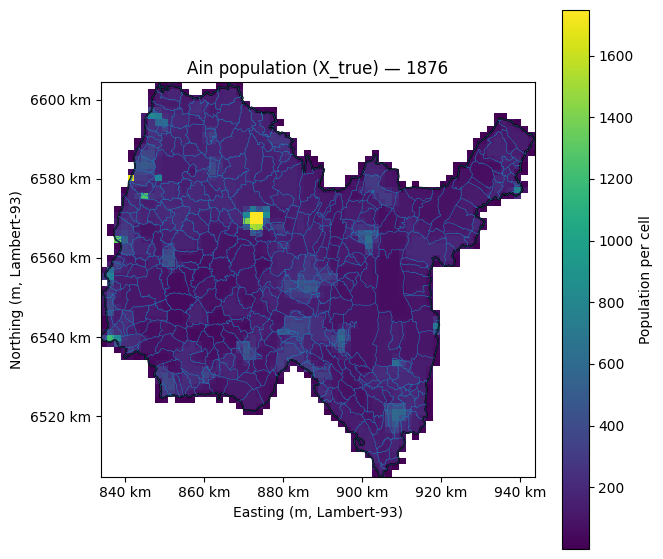

(<Figure size 700x700 with 2 Axes>,
 <Axes: title={'center': 'Ain population (X_true) — 1876'}, xlabel='Easting (m, Lambert‑93)', ylabel='Northing (m, Lambert‑93)'>)

In [3]:
# 1) Single map
vmin, vmax = 0, float(np.percentile(X_true, 99))
plot_ain_X_true(1876, draw_communes=True)

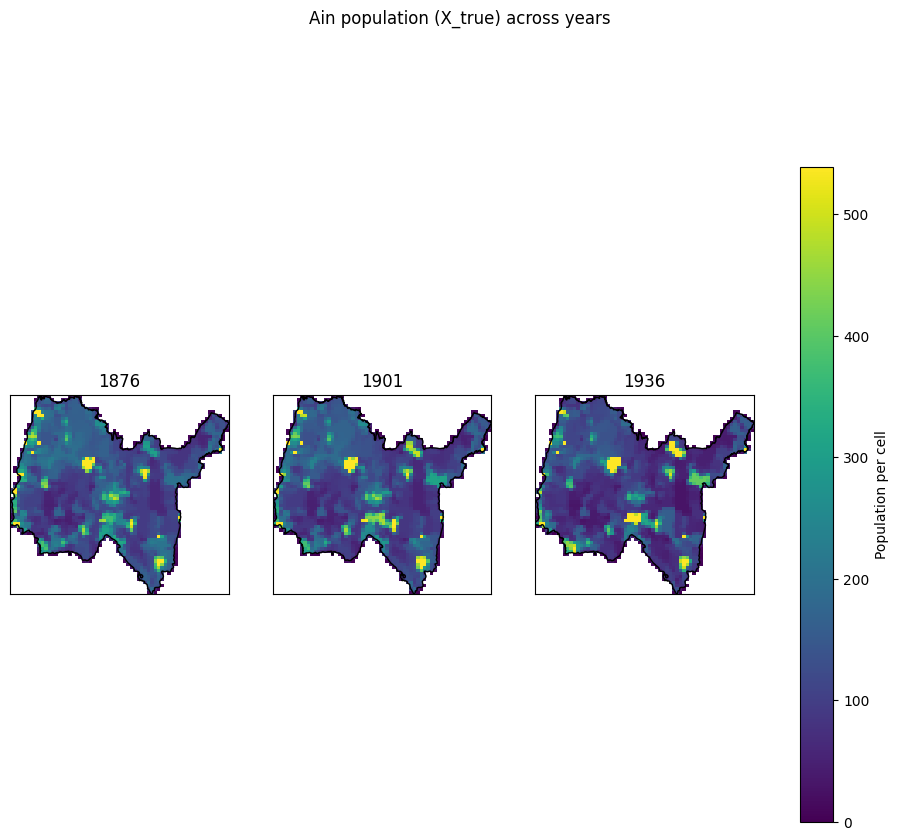

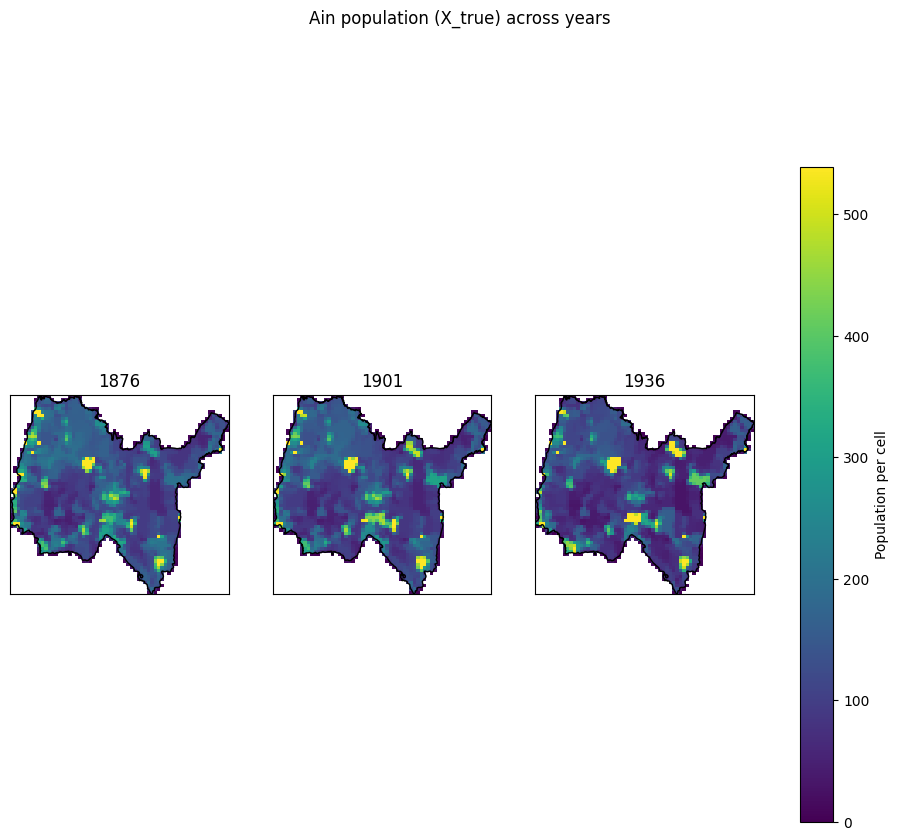

In [7]:
vmin, vmax = 0, float(np.percentile(X_true, 99))
compare_years([1876, 1901, 1936], draw_communes=False, vmin=vmin, vmax=vmax)

In [35]:
# Optimal transport
X_true  = data["X_true"]          # shape (T, N, N)
years   = data["years"].astype(int)
barrier = data["barrier"].astype(float)

num_years = years.shape[0]
T = num_years - 1 # the number of points on the time centered grid
H1 = np.stack([barrier] * T, axis = 0)
H2 = np.ones((T, barrier.shape[0], barrier.shape[1]), dtype=float)
F1 = np.zeros((T,), dtype=float)
# Linear interpolation to reduce shape to (T - 1)
time_centered_grid = [(i + 0.5) / T for i in range(T)]
time_staggered_grid  = [i / T for i in range(T + 1)]
F2 = np.interp(time_centered_grid, time_staggered_grid, np.sum(X_true.reshape(num_years, -1), axis=1)) * (1/N) * (1/N)
H = [H1, H2]
F = [F1, F2]
rho_0 = X_true[0]
rho_1 = X_true[-1]

In [36]:
import sys
sys.path.append('../../../')  # adjust if your `proximal/` lives elsewhere
from proximal.dynamicUOT import computeGeodesic
ll = (1.0, 1.0, 1.0) # size of time x space box
X_ot, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=1.0, H=H, F=F, niter=3000, big_matrix=True, verbose=True)

Computing a geodesic for optimal transport with source and constraint...


c:\Users\mao17\Workspace\pdot\venv\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Progress: 99%
Done.


In [42]:
# ===== Side-by-side plots for X_true vs X_ot =====
import numpy as np
import matplotlib.pyplot as plt

def _true_idx(year, years):
    if year not in years.tolist():
        raise ValueError(f"Year {year} not in available list {years.tolist()}")
    return int(np.where(years == year)[0][0])

def _align_true_to_ot(i_true, T_true, T_ot):
    """Map X_true index (0..T_true-1) to closest OT index (0..T_ot-1)."""
    if T_true < 2:  # degenerate
        return 0
    return int(round(i_true * (T_ot - 1) / (T_true - 1)))

def plot_Xtrue_vs_Xot(year,
                      equalize_scale=True,
                      draw_communes=False,
                      vmax=None,
                      figsize=(12,6),
                      savepath=None):
    """
    Plot a single 'year' with X_true (left) and the aligned X_ot time slice (right).
    - equalize_scale: if True, use same color scale for both panels
    - draw_communes: overlay commune borders if 'ain_com' is available
    - vmax: set an explicit max for color scale (vmin=0). If None, uses 99th percentile of the pair.
    - savepath: optional path to save the figure
    """
    # Pull globals prepared earlier in your notebook/script
    global X_true, X_ot, years, barrier, x_edges, y_edges, ain_dep, ain_com

    # Robust masking
    barrier_mask = (barrier > 0.5) if np.issubdtype(barrier.dtype, np.number) else barrier.astype(bool)

    # Indices
    i_true = _true_idx(year, years)
    T_true = X_true.shape[0]
    T_ot   = X_ot.shape[0]
    i_ot   = _align_true_to_ot(i_true, T_true, T_ot)

    # Basic safety checks
    assert X_ot.shape[1:] == X_true.shape[1:], "Grid size mismatch between X_true and X_ot"
    assert len(x_edges) == X_true.shape[2] + 1 and len(y_edges) == X_true.shape[1] + 1, "x_edges/y_edges mismatch"

    # Prepare data (mask barriers, clip tiny negatives from OT if any)
    Z_true = np.ma.array(X_true[i_true])#, mask=barrier_mask)
    Z_ot   = np.ma.array(np.clip(X_ot[i_ot], 0, None)) #mask=barrier_mask)

    # Color scaling
    vmin = 0.0
    if vmax is None:
        if equalize_scale:
            both = np.r_[Z_true.compressed(), Z_ot.compressed()]
            vmax = np.percentile(both, 99) if both.size else 1.0
        else:
            vmax = np.percentile(Z_true.compressed(), 99) if Z_true.count() else 1.0

    fig, axes = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)

    # Left: X_true
    pcm1 = axes[0].pcolormesh(x_edges, y_edges, Z_true, shading="auto", vmin=vmin, vmax=vmax)
    if 'ain_dep' in globals() and ain_dep is not None:
        ain_dep.plot(ax=axes[0], facecolor="none", linewidth=1.0)
    if draw_communes and ('ain_com' in globals()) and (ain_com is not None):
        ain_com.boundary.plot(ax=axes[0], linewidth=0.25)
    axes[0].set_aspect("equal")
    axes[0].set_title(f"X_true — {int(year)}")
    axes[0].set_xticks([]); axes[0].set_yticks([])

    # Right: X_ot (aligned step)
    pcm2 = axes[1].pcolormesh(x_edges, y_edges, Z_ot, shading="auto",
                              vmin=vmin, vmax=(vmax if equalize_scale else np.percentile(Z_ot.compressed(), 99)))
    if 'ain_dep' in globals() and ain_dep is not None:
        ain_dep.plot(ax=axes[1], facecolor="none", linewidth=1.0)
    if draw_communes and ('ain_com' in globals()) and (ain_com is not None):
        ain_com.boundary.plot(ax=axes[1], linewidth=0.25)
    axes[1].set_aspect("equal")
    axes[1].set_title(f"X_ot — step {i_ot+1}/{T_ot} (aligned to {int(year)})")
    axes[1].set_xticks([]); axes[1].set_yticks([])

    # Shared colorbar
    cbar = fig.colorbar(pcm1, ax=axes.ravel().tolist(), shrink=0.9, label="Population per cell")

    if savepath:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()
    return fig


def compare_Xtrue_Xot_many(year_list,
                           equalize_scale=True,
                           draw_communes=False,
                           ncols=2,
                           figsize_per_row=3.5,
                           savepath=None):
    """
    Small multiples: for each year in 'year_list', draw X_true (left) and the aligned X_ot (right).
    - equalize_scale: one common vmax across *all* panels (based on 99th pct of all selected pairs)
    - ncols is fixed at 2 (X_true | X_ot); we stack rows for each year.
    - figsize_per_row controls vertical size (width is auto = 2 * figsize_per_row).
    """
    global X_true, X_ot, years, barrier, x_edges, y_edges, ain_dep, ain_com

    barrier_mask = (barrier > 0.5) if np.issubdtype(barrier.dtype, np.number) else barrier.astype(bool)
    T_true, T_ot = X_true.shape[0], X_ot.shape[0]

    # Gather aligned slices
    pairs = []
    for yr in year_list:
        i_true = _true_idx(yr, years)
        i_ot = _align_true_to_ot(i_true, T_true, T_ot)
        Zt = np.ma.array(X_true[i_true], mask=barrier_mask)
        Zo = np.ma.array(np.clip(X_ot[i_ot], 0, None), mask=barrier_mask)
        pairs.append((yr, i_ot, Zt, Zo))

    # Global color scale if requested
    vmin = 0.0
    if equalize_scale:
        all_vals = np.concatenate([np.r_[Zt.compressed(), Zo.compressed()] for _,_,Zt,Zo in pairs]) if pairs else np.array([1.0])
        vmax = np.percentile(all_vals, 99) if all_vals.size else 1.0
    else:
        vmax = None

    # Figure layout
    nrows = len(pairs)
    fig, axes = plt.subplots(nrows, 2, figsize=(2*figsize_per_row, max(1, nrows)*figsize_per_row), squeeze=False)

    last_pcm = None
    for r, (yr, i_ot, Zt, Zo) in enumerate(pairs):
        # X_true
        pcm = axes[r, 0].pcolormesh(x_edges, y_edges, Zt, shading="auto", vmin=vmin, vmax=(vmax if vmax is not None else np.percentile(Zt.compressed(), 99)))
        last_pcm = pcm
        if 'ain_dep' in globals() and ain_dep is not None:
            ain_dep.plot(ax=axes[r, 0], facecolor="none", linewidth=1.0)
        if draw_communes and ('ain_com' in globals()) and (ain_com is not None):
            ain_com.boundary.plot(ax=axes[r, 0], linewidth=0.25)
        axes[r, 0].set_aspect("equal"); axes[r, 0].set_title(f"{int(yr)}"); axes[r, 0].set_xticks([]); axes[r, 0].set_yticks([])

        # X_ot
        pcm = axes[r, 1].pcolormesh(x_edges, y_edges, Zo, shading="auto", vmin=vmin, vmax=(vmax if vmax is not None else np.percentile(Zo.compressed(), 99)))
        last_pcm = pcm
        if 'ain_dep' in globals() and ain_dep is not None:
            ain_dep.plot(ax=axes[r, 1], facecolor="none", linewidth=1.0)
        if draw_communes and ('ain_com' in globals()) and (ain_com is not None):
            ain_com.boundary.plot(ax=axes[r, 1], linewidth=0.25)
        axes[r, 1].set_aspect("equal"); axes[r, 1].set_title(f"OT step {i_ot+1}/{T_ot}"); axes[r, 1].set_xticks([]); axes[r, 1].set_yticks([])

    if last_pcm is not None:
        fig.colorbar(last_pcm, ax=axes.ravel().tolist(), shrink=0.9, label="Population per cell")

    fig.suptitle("X_true vs X_ot (aligned in time)", y=0.995)
    if savepath:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()
    return fig


In [38]:
X_ot = X_ot.U.D[0]
X_ot.shape

(12, 64, 64)

In [39]:
X_ot.min(), X_ot.max()

(np.float64(0.0), np.float64(2756.100865512314))

In [40]:
X_true.min(), X_true.max()


(np.float64(0.0), np.float64(2756.100865512314))

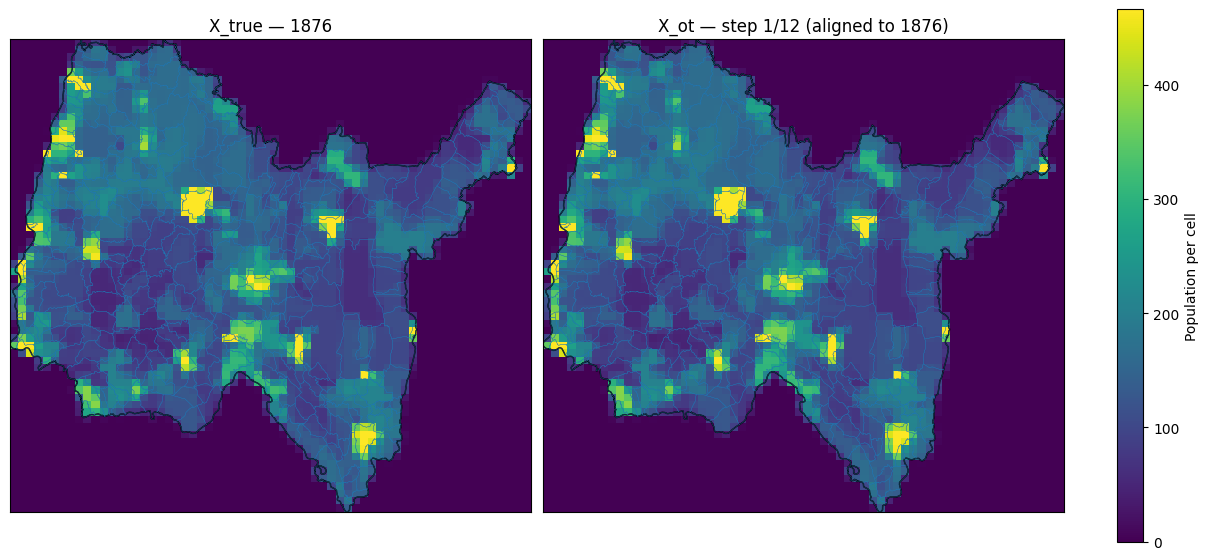

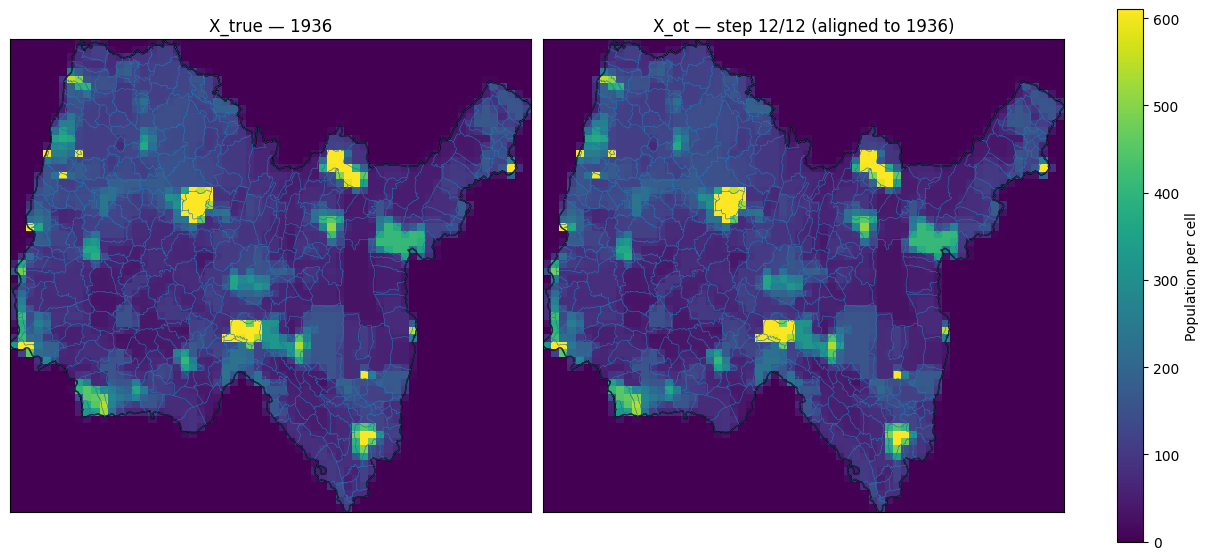

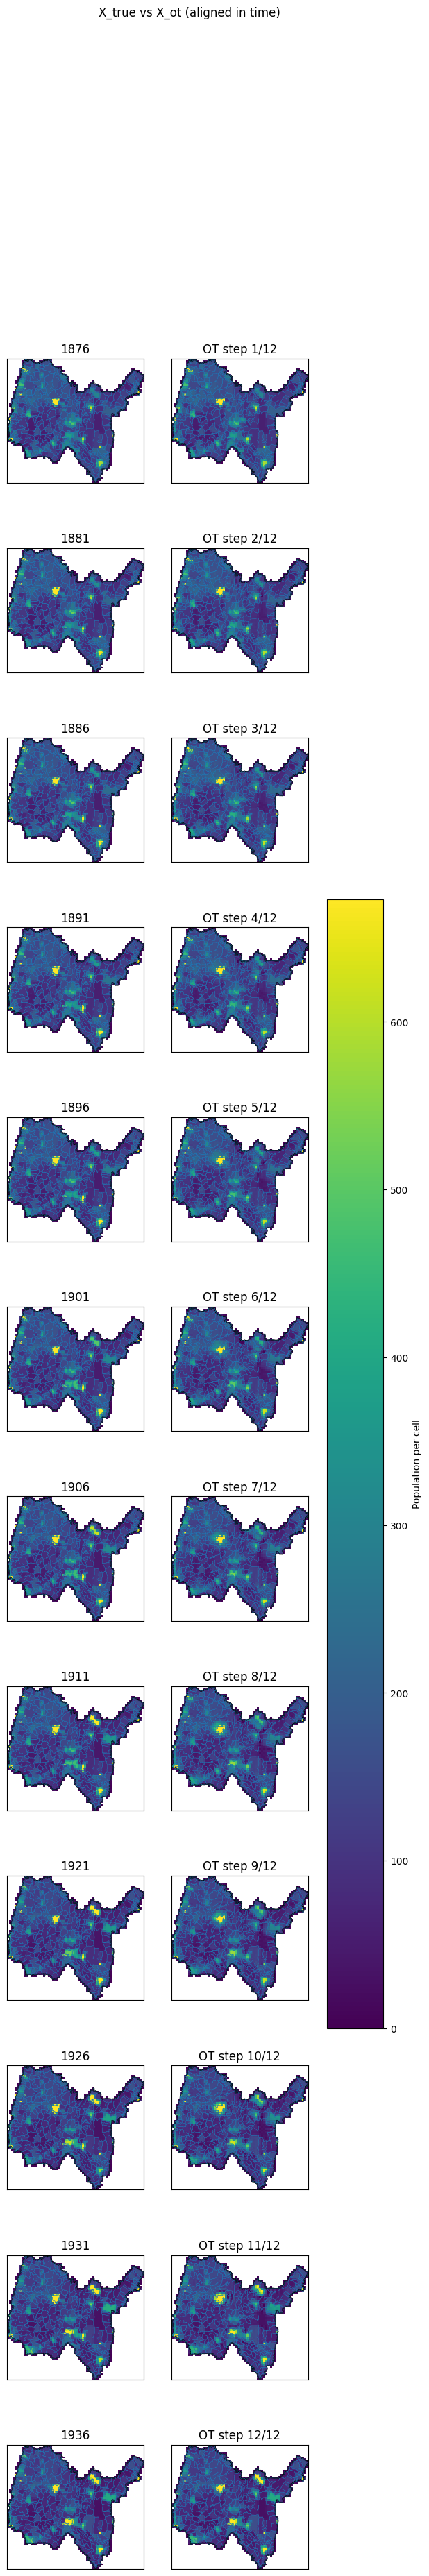

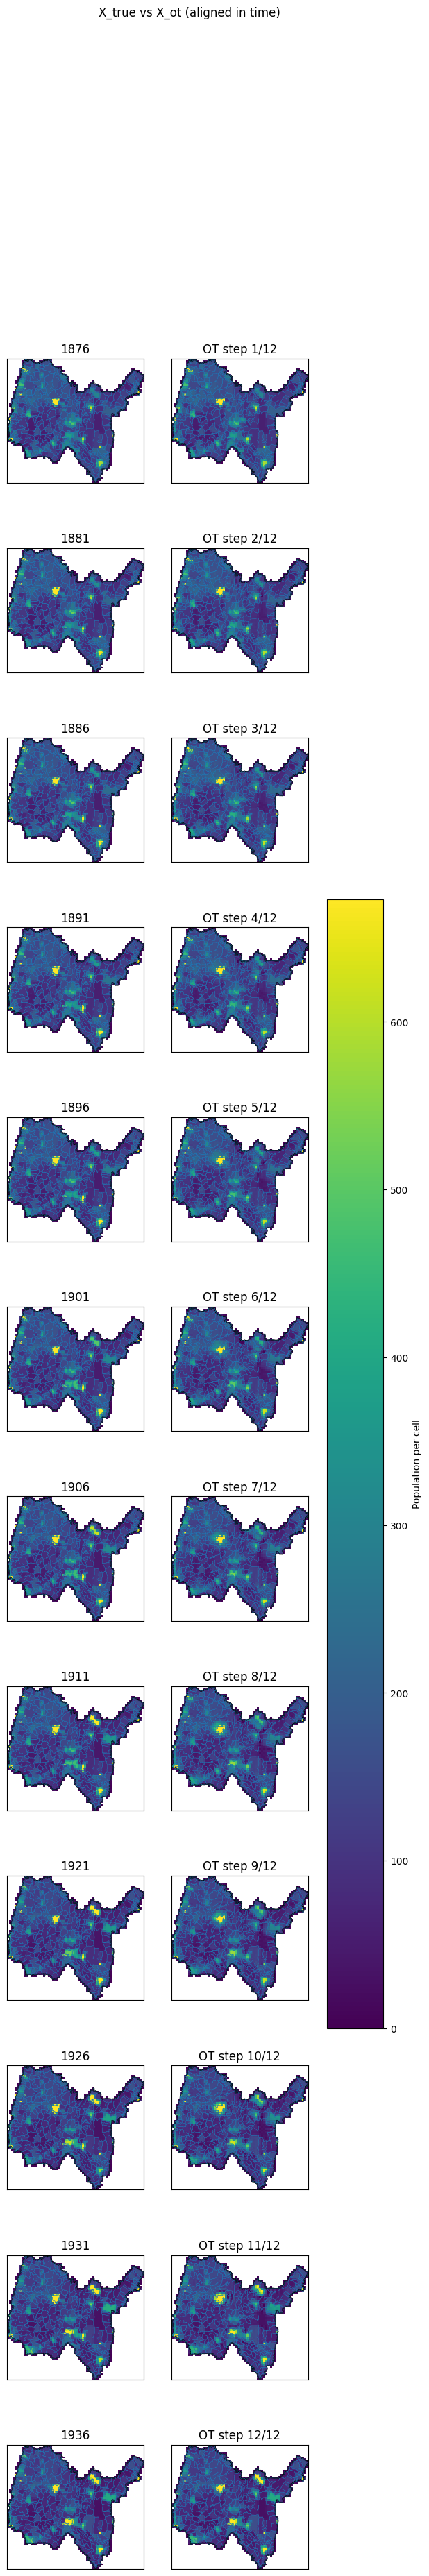

In [45]:
# Single year (e.g., start and end):
plot_Xtrue_vs_Xot(int(years[0]),  draw_communes=True)   # first year vs OT step 1
plot_Xtrue_vs_Xot(int(years[-1]), draw_communes=True)   # last year vs final OT step

# Small multiples:
compare_Xtrue_Xot_many(years,
                       draw_communes=True, equalize_scale=True)


In [69]:
import numpy as np
import matplotlib.pyplot as plt

def figure_true_ot_2row(year_list,
                        equalize_scale=True,
                        robust_pct=99,
                        draw_communes=False,
                        cmap="viridis",
                        dep_lw=0.8,
                        com_lw=0.25,
                        width_per_col=3.0,
                        height_per_row=3.0,
                        panel_labels=False,
                        savepath=None,
                        dpi=300):
    """
    Build a paper-ready figure with two rows:
      Row 1: X_true for each year in `year_list` (columns)
      Row 2: X_ot aligned to those years (columns)
    One shared colorbar on the right.

    Parameters
    ----------
    year_list : list[int]
        Years to show as columns.
    equalize_scale : bool
        If True, uses a single vmax across ALL panels (based on `robust_pct` percentile).
    robust_pct : float
        Percentile for robust color scaling (e.g., 99).
    draw_communes : bool
        Overlay commune borders if `ain_com` is available.
    cmap : str
        Matplotlib colormap (e.g., "viridis", "magma", "plasma").
    dep_lw, com_lw : float
        Line widths for department boundary and commune boundaries.
    width_per_col, height_per_row : float
        Size controls in inches.
    panel_labels : bool
        If True, annotate panels (a), (b), … in row-major order.
    savepath : str | None
        If given, save to this path. Use .pdf or .svg for vector output.
    dpi : int
        DPI when saving to raster formats (PNG, JPG).

    Returns
    -------
    (fig, axes)
    """
    # Expect these to be defined already (per your notebook/script):
    # X_true, X_ot, years, barrier, x_edges, y_edges, ain_dep, ain_com
    global X_true, X_ot, years, barrier, x_edges, y_edges, ain_dep, ain_com

    # --- utilities ---
    def _idx_year(yr):
        if yr not in years.tolist():
            raise ValueError(f"Year {yr} not in available list {years.tolist()}")
        return int(np.where(years == yr)[0][0])

    def _align_true_to_ot(i_true, T_true, T_ot):
        if T_true < 2:
            return 0
        return int(round(i_true * (T_ot - 1) / (T_true - 1)))

    # --- checks ---
    assert X_ot.shape[1:] == X_true.shape[1:], "Grid size mismatch between X_true and X_ot"
    assert len(x_edges) == X_true.shape[2] + 1 and len(y_edges) == X_true.shape[1] + 1, "x_edges/y_edges mismatch"

    # Barrier to boolean mask
    barrier_mask = (barrier > 0.5) if np.issubdtype(barrier.dtype, np.number) else barrier.astype(bool)

    T_true, T_ot = X_true.shape[0], X_ot.shape[0]

    # Gather slices, aligned steps, and values for scaling
    Z_true_list, Z_ot_list, steps = [], [], []
    for yr in year_list:
        i_true = _idx_year(yr)
        i_ot   = _align_true_to_ot(i_true, T_true, T_ot)
        Zt = np.ma.array(X_true[i_true], mask=barrier_mask)
        Zo = np.ma.array(np.clip(X_ot[i_ot], 0, None), mask=barrier_mask)
        Z_true_list.append(Zt); Z_ot_list.append(Zo); steps.append(i_ot)

    # Robust color scale
    vmin = 0.0
    if equalize_scale:
        all_vals = np.concatenate([Z.compressed() for Z in (Z_true_list + Z_ot_list)]) if (Z_true_list or Z_ot_list) else np.array([1.0])
        vmax = np.percentile(all_vals, robust_pct) if all_vals.size else 1.0
    else:
        vmax_true = np.percentile(np.concatenate([Z.compressed() for Z in Z_true_list]), robust_pct)
        vmax_ot   = np.percentile(np.concatenate([Z.compressed() for Z in Z_ot_list]), robust_pct)
        vmax = max(vmax_true, vmax_ot)

    # Figure & axes (2 rows, C columns)
    C = len(year_list)
    fig_w = max(2.0, width_per_col * C)
    fig_h = max(2.0, height_per_row * 2)
    fig, axes = plt.subplots(2, C, figsize=(fig_w, fig_h), squeeze=False)

    # Layout: leave room at right for a tall colorbar
    fig.subplots_adjust(left=0.06, right=0.9, top=0.98, bottom=0.08, wspace=0.02, hspace=0.02)

    # Panel label helper
    def _label(ax, text):
        ax.text(0.01, 0.99, text, transform=ax.transAxes, ha="left", va="top",
                fontsize=10, fontweight="bold",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, pad=2))

    last_pcm = None
    # Row 1: X_true
    for c, (yr, Zt) in enumerate(zip(year_list, Z_true_list)):
        ax = axes[0, c]
        pcm = ax.pcolormesh(x_edges, y_edges, Zt, shading="auto", vmin=vmin, vmax=vmax, cmap=cmap)
        last_pcm = pcm
        if 'ain_dep' in globals() and ain_dep is not None:
            ain_dep.plot(ax=ax, facecolor="none", linewidth=dep_lw)
        if draw_communes and ('ain_com' in globals()) and (ain_com is not None):
            ain_com.boundary.plot(ax=ax, linewidth=com_lw)
        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f"{int(yr)}", fontsize=20)
        if c == 0:
            pass
            #ax.set_ylabel("X_true", fontsize=11)
        if panel_labels:
            _label(ax, f"({chr(ord('a') + c)})")

    # Row 2: X_ot
    for c, (Zo, i_ot) in enumerate(zip(Z_ot_list, steps)):
        ax = axes[1, c]
        pcm = ax.pcolormesh(x_edges, y_edges, Zo, shading="auto", vmin=vmin, vmax=vmax, cmap=cmap)
        last_pcm = pcm
        if 'ain_dep' in globals() and ain_dep is not None:
            ain_dep.plot(ax=ax, facecolor="none", linewidth=dep_lw)
        if draw_communes and ('ain_com' in globals()) and (ain_com is not None):
            ain_com.boundary.plot(ax=ax, linewidth=com_lw)
        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])
        # Small caption with OT step count (aligned)
        #ax.set_xlabel(f"OT step {i_ot+1}/{T_ot}", fontsize=9, labelpad=2)
        if c == 0:
            pass
            #ax.set_ylabel("X_ot", fontsize=11)
        if panel_labels:
            _label(ax, f"({chr(ord('a') + C + c)})")

    # Shared vertical colorbar
    if last_pcm is not None:
        pass
        #cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        #cb = fig.colorbar(last_pcm, cax=cax)
        #cb.set_label("Population per cell", fontsize=10)

    # Save if requested
    if savepath:
        ext = str(savepath).split(".")[-1].lower()
        if ext in ("pdf", "svg"):
            fig.savefig(savepath, bbox_inches="tight")
        else:
            fig.savefig(savepath, dpi=dpi, bbox_inches="tight")

    return fig, axes


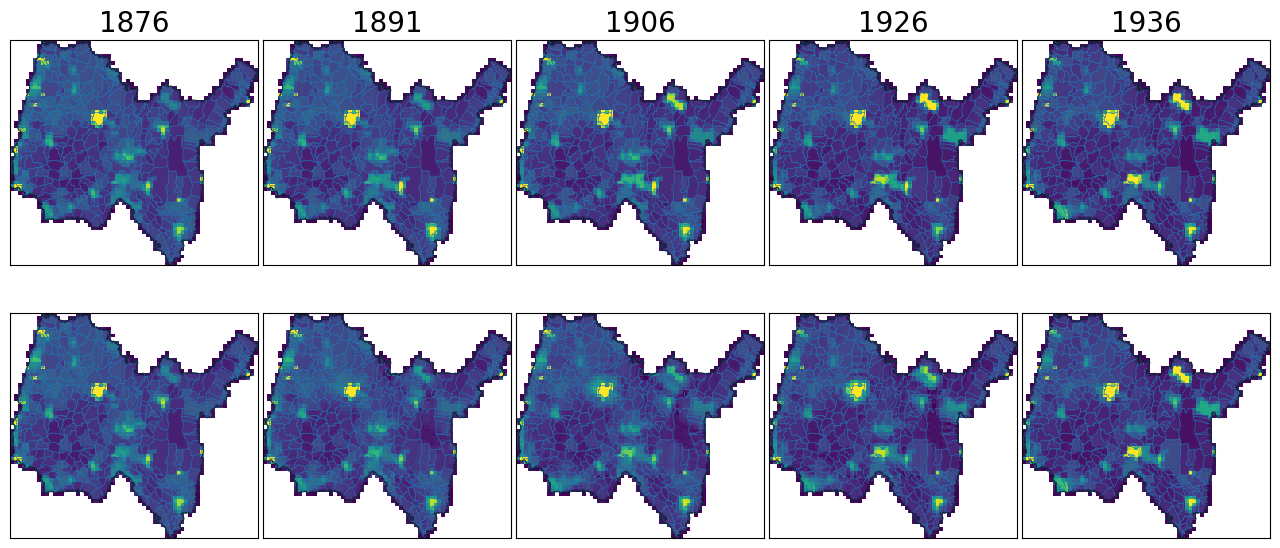

In [71]:
# Columns = first year, 1906, last year
fig, axes = figure_true_ot_2row(
    list(years[::3]) + [years[-1]],
    draw_communes=True,
    #panel_labels=True,              # (a), (b), …
    savepath="data/output/ain_true_vs_ot.png"  # raster output for the paper
)